<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%81%20%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Написать блоки:

1. Моделируем нейросеть.

2. Задаем функцию потерь в соответствии с вознаграждением.

3. Генерация игрового эпизода с участием нейросети.

4. Обучаем сеть на серии игровых эпизодов.


In [2]:
!pip install tensorflow==1.15 -q

     |████████████████████████████████| 412.3MB 38kB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 512kB 57.3MB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [3]:
pip install keras==2.3 -q

     |████████████████████████████████| 378kB 26.0MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gym               #"тренажер" Gym из платформы OpenAi, предоставляющий среду для работы над обучением с подкреплением 
import numpy as np 
import keras       
from keras.models import Model, load_model 
from keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply 
from keras.optimizers import RMSprop, Adam 
import time                                
import matplotlib.pyplot as plt            #библиотекa для визуализации данных

%matplotlib inline

Using TensorFlow backend.


## View:




In [5]:
env = gym.make('Pong-v0')                  # создаем среду игры Понг средствами OpenAI Gym('env' = environment)
observation = env.reset()                  # задаем начальное состояние среды, которое наблюдает агент
print("формa состояния среды:", observation.shape)         
                          

формa состояния среды: (210, 160, 3)


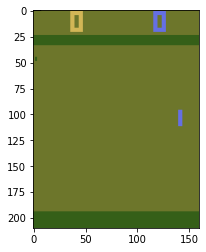

In [6]:
plt.imshow(observation)                   # визуализация состояния среды с помощью метода imshow от matplotlib.pyplot
plt.show() 

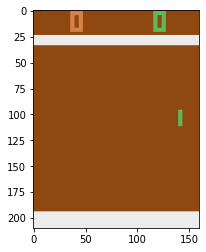

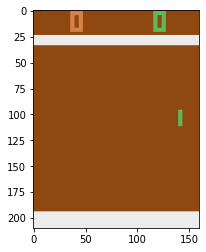

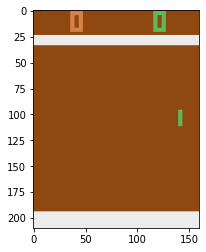

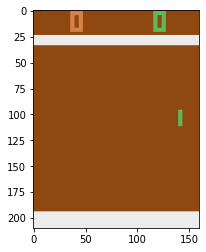

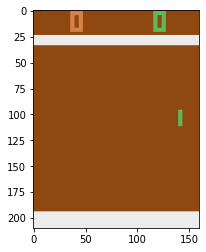

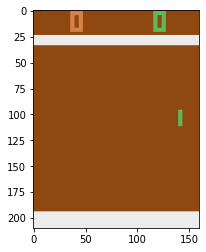

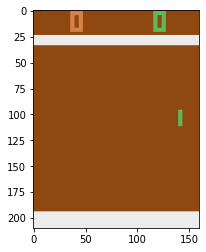

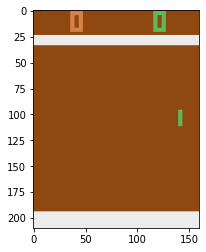

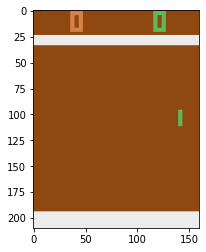

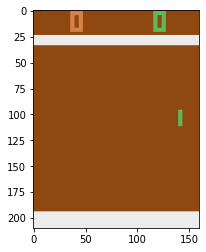

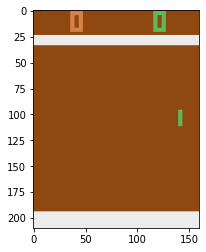

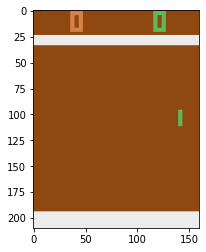

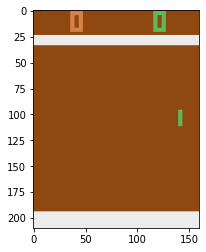

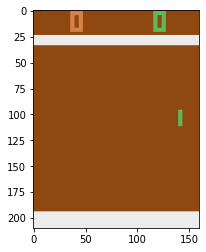

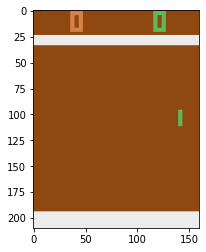

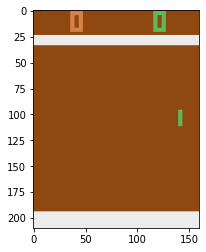

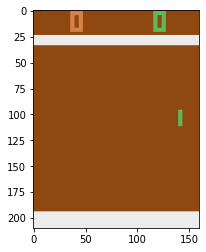

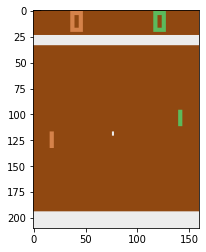

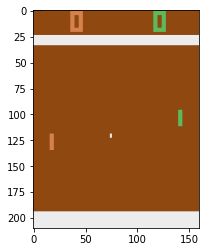

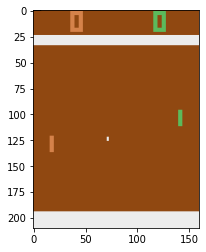

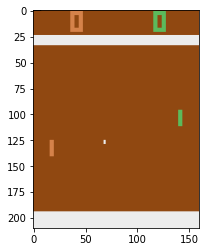

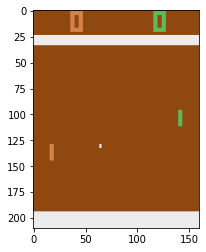

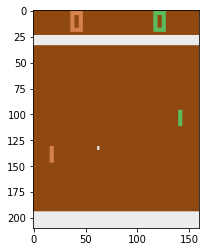

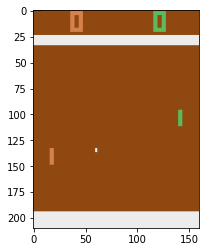

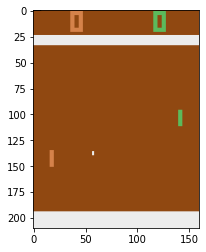

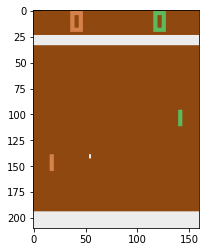

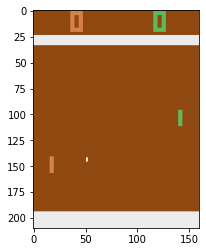

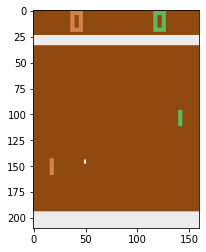

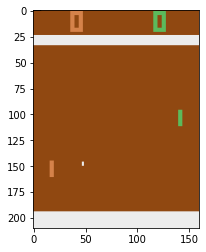

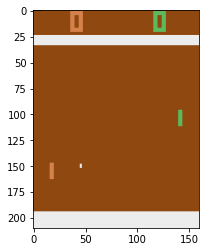

'\n  step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)\n  observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)\n  reward (float) - награда за совершённое действие\n  done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)\n  info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)\n'

In [7]:
""""
  В понге:
  0 цифровое обозначение если ракетка 'остаётся на месте'
  2 цифровое обозначение для действия ракеткой 'сдвинуться вверх'
  3 цифровое обозначение для действия ракеткой 'сдвинуться вниз'
"""
# Проиграю вперёд игру на 30 кадров чтобы увидеть полную сцену игры
for i in range(30):
  
    observation, reward, done, info = env.step(0)    # 0 обозначает,что ничего не делаем, остаемся на месте
    plt.imshow(observation)                          # текущее состояние среды: наш агент владеет зелёной ракеткой, появился соперник и мяч
    plt.show()
"""
  step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
  observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
  reward (float) - награда за совершённое действие
  done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
  info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)
"""

###Policy(политику, стратегию агента) будет позже задавать нейросеть.
Подадим ей разницу между новым и предыдущим кадром, чтобы отслеживалось смещение мяча/ракеток и данные были понятными

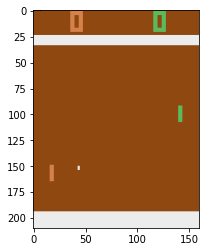

In [8]:
newObservation, reward, done, info = env.step(2)   # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation)                         # взглянем на следующий кадр(нам смещение едва видно, либо не видно, т.к визуально длина шага мала)

## Функция предобработки данных для подачи в нейросеть:
###оставляю на экране лишь мяч и ракетки


In [12]:
def preprocessFrames(newFrame, lastFrame): # подаем в функцию новый и предыдущий кадр

    nFrame = newFrame.astype(np.int32)      # переводим в целочисленный тип новый кадр
    nFrame[nFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
    nFrame[nFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
    lFrame = lastFrame.astype(np.int32)     # переводим в целочисленный тип предыдущий кадр
    lFrame[lFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
    lFrame[lFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
    deltaFrame = nFrame - lFrame            # задаём разницу между новым и предыдущим кадром 
     
    # Отрезаем верхнюю и нижнюю(неинформативные) части экрана, по 35 сверху и снизу
    deltaFrame = deltaFrame[35:195]         # срезали края по высоте, осталась картинка 160*160
    # Делаем сжатие кадра в 2 раза по обеим сторонам изображения и оставляем монотонный канал 
    deltaFrame=deltaFrame[::2,::2, 0]
    # Масштабирование чисел от 0 до 1
    maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
    if maxValue != 0:
        deltaFrame=deltaFrame/maxValue
    return deltaFrame                       # функция вернет разницу между кадрами в оптимальном виде

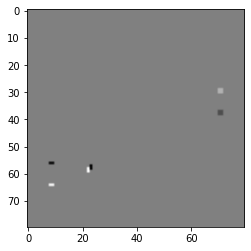

In [13]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray)  # выведем результат предобработки наших кадров

# смещение здесь - это шаг от черного пикселя к светлому

In [14]:
preprocessFrames(newObservation, observation)         # выведем массив для этого состояния среды(кадра)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
print("формa массива:", preprocessFrames(newObservation, observation).shape)  

формa массива: (80, 80)


In [ ]:
"""
  Cостоянием среды будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет 
  заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
  Далее keras'ом создадим policy, которая на основе состояния(картинки) выбирает действия.
  Output сети - вероятность того что нужно двигаться вверх
"""

## Задание №1: моделирую нейросеть:


In [16]:

inputs = Input(shape=(80,80))                                                       # на входе изображение 80*80

flattenedLayer = Flatten()(inputs)                                                  # в вектор
fullConnected = Dense(200, activation="relu", use_bias=False)(flattenedLayer)       # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation="sigmoid", use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
policyNetworkModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


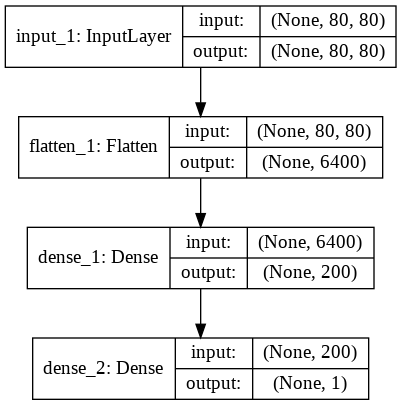

In [18]:
from keras.utils import plot_model

plot_model(policyNetworkModel, show_shapes=True, show_layer_names=True)

##Задание №2: создаю функцию потерь в соответствии с вознаграждением
####episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываю reset)


In [19]:
episodeReward = Input(shape=(1,), name='episodeReward')       # наградa за эпизод

In [ ]:
"""
  Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаю
  функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
"""

In [20]:
def rewardedLoss(episodeReward):            # задаем новую функцию потерь, принимающую episodeReward(награда)

  def loss(yTrue,yPred):
      """
        подаю в кач-ве yTrue фактически сделанное действие(action) 
        если фактически сделанное действие было движением вверх - подаю 1 на yTrue, если нет то подаю 0
        yPred - выход сетки(вероятность выбора движения вверх)
        мы не подаём yPred в нейронку, его вычисляет керас
      """
      # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
      tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
      """
        вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
        помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
        формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
      """
      tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
      # обновленная функция потерь - "функция политики"
      policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
      return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

## керас-оптимизатор и нейро-сеть для обучения:

In [21]:
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

##Задание №2.Генерация игрового эпизода с участием нейросети



In [22]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

###Генерирую эпизод игры с необученной сетью:

In [23]:
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)


Количество состояний в эпизоде = 1300
Форма состояния (80, 80)
Количество наград за эпизод = 1300


In [24]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# вероятность в районе 50% - сеть пока не понимает куда лучше шагать

[0.51235104, 0.5067449, 0.50546384, 0.49668273, 0.47848165, 0.5163412, 0.5006833, 0.4760211, 0.4699415, 0.49498022, 0.49872315, 0.50757647, 0.50551146, 0.5064931, 0.49793747, 0.49887085, 0.4775891, 0.49182162, 0.5141415, 0.5106939]


In [25]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]

In [26]:
print("список наград:", rewardsList[50:70])

список наград: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


###Количество игр в эпизоде:

In [27]:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList)))))   # берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList)))))  # берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList)))))    #с фильтром по 0

Количество выигранных очков = 1
Количество проигранных очков = 21
Количество нулевых наград = 1278


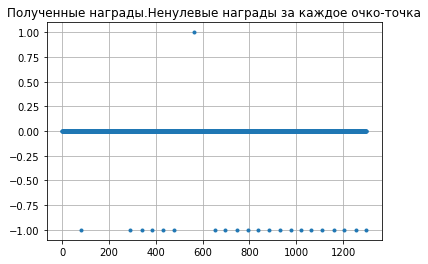

In [28]:
plt.plot(rewardsList, '.') # точки будут наградами на графике
plt.title("Полученные награды.Ненулевые награды за каждое очко-точка")
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

## Эффективно определяем вознаграждение



In [29]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1, -1, -1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

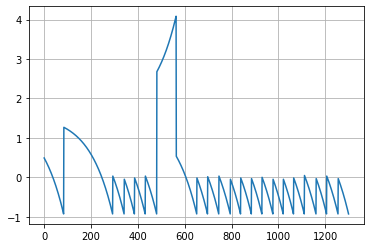

In [30]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca()                            # текущие оси
ax.grid(True)  
# новое распределение наград даст лучшее отражение эффективности действий

## Задание №3: игровой эпизод с последующей тренировкой сети




In [31]:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)   # Сгенерируем новый игровой эпизод:
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = ", str(len(statesList)))                                       # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = ", str(statesList[0].shape))                                        # выведем форму для каждого состояния
print("Список наград  = ", str(len(rewardsList)))                                                  # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды =  1347
Форма состояний среды =  (80, 80)
Список наград  =  1347


### Готовлю данные для тренировки:

In [32]:
x = np.array(statesList)                                          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1)    # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList)                                 # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)                                   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape)            # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)                         # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)                # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1347, 1)
Форма состояний среды = (1347, 80, 80)
Форма фактических движений = (1347, 1)


In [33]:
episodeReward[:15]

array([[1.2299055 ],
       [1.2099948 ],
       [1.189883  ],
       [1.1695682 ],
       [1.1490481 ],
       [1.1283206 ],
       [1.1073838 ],
       [1.0862355 ],
       [1.0648737 ],
       [1.043296  ],
       [1.0215005 ],
       [0.99948466],
       [0.97724646],
       [0.9547837 ],
       [0.93209404]], dtype=float32)

In [34]:
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)     # "Скормим" модели новые 'x' и 'y'

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
1347/1347 [==============================] - 0s 153us/step - loss: 2.1333e-04


###Серия игровых эпизодов, Затем предобработаем данные для нейросети:

In [35]:
def generateEpisodeBatchesTraining(model, nBatches=10):   # подаем на вход заданное количество игровых серий

    env = gym.make('Pong-v0')                             # создаем игровую среду Pong
    batchStateList = []                                   # зададим серию списков состояний
    batchUpDownActionList = []                            # зададим серию списков движений
    batchRewardsList = []                                 # зададим серию списков наград
    batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
    for i in range(nBatches):                             # для каждой серии 
        statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
        batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
        batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
        batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
        batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
  
    episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
    x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
    yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
    yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
    
    history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
    
    batchLoss = history.history['loss'][-1]
    return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
    # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

## Задание №4: обучение сети на серии игровых эпизодов



In [36]:
trainingTimes = 12                    # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
    startTime = time.time()
    # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
    statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
    endTime = time.time()
    print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
    print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
    print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
    rr=np.array(rewardsList)                                             # сформируем все награды
    print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
    print("")
    if training % 10 == 0:                                               # через каждые 10 эпизодов
        policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
        policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
        with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
            recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
            recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 57сек
Ошибка на тренировке = -0.02672
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 2
Время тренировки = 61сек
Ошибка на тренировке = -0.03848
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 3
Время тренировки = 52сек
Ошибка на тренировке = -0.04529
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 4
Время тренировки = 62сек
Ошибка на тренировке = -0.04122
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 5
Время тренировки = 61сек
Ошибка на тренировке = -0.05561
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 6
Время тренировки = 65сек
Ошибка на тренировке = -0.04666
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 7
Время тренировки = 63сек
Ошибка на тренировке = -0.05654
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 8
Время тренировки = 69сек
Ошибка на тренировке = -0.04177
Выиграли очков = 17 Проиграли очков = 210

Тренировка = 9
Время тренировки = 63сек
Ошибка на тренировке = -0.03479
Выиграли очк

## Эпизод на обученной модели и видео:

In [37]:
from IPython.display import clear_output         # Импорт библиотек для записи и воспроизведения видео
!apt update && apt install xvfb && pip install pyvirtualdisplay 
# # "apt-get..." - установка пакета программного обеспечения
# # "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран

from gym.wrappers import Monitor    # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob                         # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64                       # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
clear_output()
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

### Fункции записи и воспроизведения видео:

In [38]:
def wrapEnv(env):                           # зададим функцию-обёртку над средой

    env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
    return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
  
def showVideo():                            # функция для воспроизведения видео в ноутбуке

    mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
    if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
        mp4 = mp4list[0]                        # то берём самый свежий файл
        video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
        encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
    else:                           # если путь не нашелся 
      print("Could not find video") # то выведем на печать, что не смог найти видео

###Функция сыграть и показать игру:

In [39]:
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети

    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close()                                                     # закрываем игровую среду после окончания игры
    showVideo()                                                     # показать видео игры

In [40]:
playAndShowEpisode(policyNetworkModel)       